In [ ]:
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.datasets import load_svmlight_file
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
import os, glob
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn import linear_model

In [ ]:
!git clone https://github.com/dsakharuk/551assignment2.git  # cloning into my repo that has the data for imdb reviews

fatal: destination path '551assignment2' already exists and is not an empty directory.


### Preprocessing imdb Data

In [ ]:
train_pos_folder = "551assignment2/train/pos"
train_neg_folder = "551assignment2/train/neg"
test_pos_folder = "551assignment2/test/pos"
test_neg_folder = "551assignment2/test/neg"
files1 = []
files2 = []
files3 = []
files4 = []

#Combining all individual text files into a list of dfs
files1 = [pd.read_csv(file, delimiter='\t', names =['text'] ) for file in glob.glob(os.path.join(train_pos_folder ,"*.txt"))]
files2 = [pd.read_csv(file, delimiter='\t', names =['text'] ) for file in glob.glob(os.path.join(train_neg_folder ,"*.txt"))]
files3 = [pd.read_csv(file, delimiter='\t', names =['text'] ) for file in glob.glob(os.path.join(test_pos_folder ,"*.txt"))]
files4 = [pd.read_csv(file, delimiter='\t', names =['text'] ) for file in glob.glob(os.path.join(test_neg_folder ,"*.txt"))]

In [ ]:
#combining all individual df lists into one large df
train_pos_imdb = pd.concat(files1)
train_neg_imdb = pd.concat(files2)
test_pos_imdb = pd.concat(files3)
test_neg_imdb = pd.concat(files4)

In [ ]:
#Setting arrays for the vocab and tokenized features
vocab =  np.loadtxt('551assignment2/imdb.vocab',dtype=str)

X_train,Y_tr = load_svmlight_file("551assignment2/train/labeledBow.feat")


In [ ]:
#Converting to sparse column matrix
X_train_tmp = X_train.tocsc()
#get count of nonzero elements per column. A.k.a the amount of reviews that contain given word
Count_non_zero_train = X_train_tmp.getnnz(axis=0)

#Get all indicies where the count is more than 50% of total entries and less than 1%
Above_50 = np.where(Count_non_zero_train > 12500)
Below_1 = np.where(Count_non_zero_train < 250)
range_train = (Above_50[0][-1],Below_1[0][0])

base = np.arange(89527)

temp = np.setdiff1d(base,Below_1[0])
temp = np.setdiff1d(temp,Above_50[0])

temp_opposite = np.setdiff1d(base,temp)


#Converting vocab list
trimmed_vocab = np.copy(vocab)
np.put(trimmed_vocab, temp_opposite, [''])
trimmed_vocab = trimmed_vocab[trimmed_vocab != '']


#Show all words that will be in model
print(trimmed_vocab)




['he' 'his' '!' ... 'opens' 'essentially' 'received']


Removing columns with unnecessary features from the X_train matrix

In [ ]:
X_train_new = X_train[:,temp]

Standardizing inputs and finding z scores

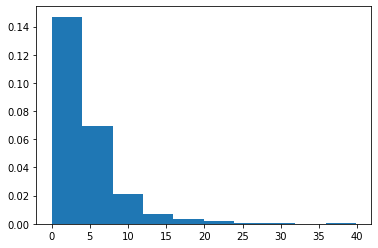

The most positive words are:
loved
also
perfect
favorite
wonderful
best
love
great
amazing
excellent
The most negative words are:
no
bad
?
worst
awful
terrible
even
waste
worse
horrible


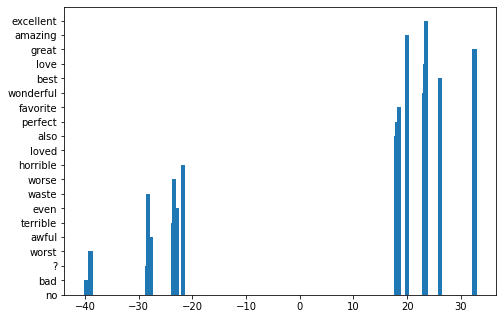

In [ ]:
N= 25000
scaler = StandardScaler(with_mean=False)
X_train_standardized = normalize(X_train_new, norm='l1', axis=1)
scaler.fit(X_train_standardized)
X_train_standardized = scaler.transform(X_train_standardized)


y_std = Y_tr.std()
y_mean = Y_tr.mean()

Y_tr = (Y_tr-y_mean)/y_std

Z_scores = (X_train_standardized.transpose() * Y_tr)/np.sqrt(N)
Z_scores_abs = np.absolute(Z_scores)


top_500_greatest = np.argpartition(Z_scores, -500)[-500:]
top_500_greatest = np.sort(top_500_greatest)

#Final dictionary of top K features
top_k_greatest_opposite = np.argpartition(Z_scores, -500)[:-500]
train_vocab = np.copy(trimmed_vocab)
np.put(train_vocab, top_k_greatest_opposite, [''])
train_vocab = train_vocab[train_vocab != '']
#print(train_vocab)

#Plotting density of absolute valued z scores
plt.hist(Z_scores_abs, bins=10,density=True)
plt.show()



#finding top 10 most positive Z scores
largest= np.argpartition(Z_scores, -10)[-10:]
largest_scores = []
largest_words = []
print("The most positive words are:")
for i in largest:
  largest_scores.append(Z_scores[i])
  largest_words.append(trimmed_vocab[i])
  print(trimmed_vocab[i])


#finding top 10 most negative Z scores
smallest = np.argpartition(Z_scores, 10)[:10]
smallest_scores = []
smallest_words = []
print("The most negative words are:")
for i in smallest:
  smallest_scores.append(Z_scores[i])
  smallest_words.append(trimmed_vocab[i])
  print(trimmed_vocab[i])


#Punctuation will be removed from vocab when vectorizing data



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = smallest_words + largest_words
x = smallest_scores + largest_scores
#print(x)
ax.bar(x,y)
plt.show()




Vectorizing training and testing data


In [ ]:
#combining and reshaping the train and test inputs
x_train_imdb = pd.concat([train_pos_imdb,train_neg_imdb])
x_train_imdb = x_train_imdb.to_numpy()
x_train_imdb.ravel()
y_train_imdb = np.concatenate((np.ones(12500),np.zeros(12500)))
x_test_imdb = pd.concat([test_pos_imdb,test_neg_imdb])
x_test_imdb = x_test_imdb.to_numpy()
x_test_imdb.ravel()
y_test_imdb = np.concatenate((np.ones(12500),np.zeros(12500)))


x_train_imdb = x_train_imdb.flatten()
x_test_imdb = x_test_imdb.flatten()

#Vectorizing the training and testing data with previously determined vocabulary
vectorizer = CountVectorizer(vocabulary=train_vocab,stop_words=["!","?","/",".",",","#","%","@"])
X_train_vector = vectorizer.fit_transform(x_train_imdb)
X_test_vector = vectorizer.fit_transform(x_test_imdb)

X_train_vector_array =X_train_vector.toarray()
X_train_vector_df = pd.DataFrame(data=X_train_vector_array,columns = vectorizer.get_feature_names())

X_test_vector_array =X_test_vector.toarray()
X_test_vector_df = pd.DataFrame(data=X_test_vector_array,columns = vectorizer.get_feature_names())



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test_vector_df.head()

,he,his,by,an,who,from,her,has,good,more,...,vhs,finest,deserved,understanding,keeping,delightful,loving,witty,discovered,received
0,5,1,1,2,0,1,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,3,1,1,1,0,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,4,4,0,1,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing News Groups data

In [ ]:
newsgroup_data =  sklearn.datasets.fetch_20newsgroups 

#Choosing categories
categories = ['rec.autos', 'soc.religion.christian','comp.graphics', 'rec.sport.hockey']

twenty_train = newsgroup_data(subset='train',categories=categories, shuffle=True, random_state=42,remove=['headers','footers','quotes'])
twenty_test = newsgroup_data(subset='test',categories=categories, shuffle=True, random_state=42,remove=['headers','footers','quotes'])
twenty_all = newsgroup_data(subset='all',categories=categories, shuffle=True, random_state=42,remove=['headers','footers','quotes'])


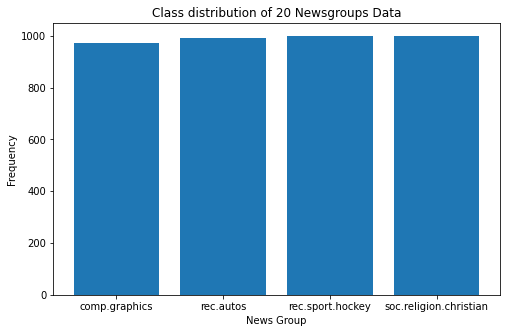

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Finding frequency of each category
_, frequency = np.unique(twenty_all.target, return_counts=True)
targets_str = np.array(twenty_all.target_names)

# Training data class distribution
plt.figure(figsize=(8,5))
plt.bar(targets_str,frequency)

plt.title('Class distribution of 20 Newsgroups Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()
plt.figure()

In [ ]:
train_df = pd.DataFrame({'data': twenty_train.data, 'target': twenty_train.target})
train_df.head()

,data,target
0,I guess that makes Altima the most generic car...,1
1,"Hi Damon, No matter what system or explanatio...",3
2,Romans 8:28 (RSV) We know that in everything...,3
3,\n\n Are you using the traditional radiosity m...,0
4,\n[stuff about autobahn and safety of sho at s...,1


In [ ]:
test_df = pd.DataFrame({'data': twenty_test.data, 'target': twenty_test.target})
test_df.head()

,data,target
0,Can the Sabres win two more games against the ...,2
1,"Hello,\n I am moving to Houston to go to Rice...",1
2,"\n\n\nKidding, right? \n\nCorvette, several MB...",1
3,so all us hockey/automobile racing fans all kn...,2
4,I'm certainly no engineer and really have no s...,1


In [ ]:
all_df = pd.DataFrame({'data': twenty_all.data, 'target': twenty_all.target})
all_df.head()

,data,target
0,\n CH> Concerning the proposed newsgroup spli...,0
1,"Tom Barrasso wore a great mask, one time, last...",2
2,\n\nThat's a good way to put it. It's a quiet...,2
3,The best auto-shifters on the street (AND NOT ...,1
4,\nLosers like us? You are the fucking moron wh...,2



Preprocess Text

*   We need to remove: numbers, special characters
*   We need to convert the remaining text to lowercase







In [ ]:
preprocessor = []
chars = ["\n",'\r','\t','"',',', '-', '_' '*', '=', '!', '.', '?', ':', '@', ';']

for c in chars:
    preprocessor.append(lambda x: x.replace(c, " "))

temp_train = train_df.data.map(lambda x: x.lower())
temp_test = test_df.data.map(lambda x: x.lower())
temp_all = all_df.data.map(lambda x: x.lower())

for p in preprocessor: 
  temp_train = temp_train.map(p)
  temp_test = temp_test.map(p)
  temp_all = temp_all.map(p)


train_df['data'] = temp_train
test_df['data'] = temp_test
all_df['data'] = temp_all

all_df.head()

,data,target
0,\n ch> concerning the proposed newsgroup spli...,0
1,"tom barrasso wore a great mask, one time, last...",2
2,\n\nthat's a good way to put it. it's a quiet...,2
3,the best auto-shifters on the street (and not ...,1
4,\nlosers like us? you are the fucking moron wh...,2


In [ ]:
from sklearn.feature_selection import mutual_info_classif as MIC

tfid = TfidfVectorizer(stop_words='english' ,max_features=1000) #remove noisy features
all_features =tfid.fit_transform(all_df.data).toarray()
all_labels = all_df.target
vocab = tfid.vocabulary_

tfid2= TfidfVectorizer(vocabulary=vocab)

train_features = tfid2.fit_transform(train_df.data).toarray()
train_labels = train_df.target
test_features = tfid2.fit_transform(test_df.data).toarray()
test_labels = test_df.target

X_new_all = all_features
Y_new_all = all_labels

X_train_new_cleaned = train_features
Y_train_new_ = train_labels

X_test_new_cleaned = test_features
Y_test_new_ = test_labels

mi_score = MIC(all_features,all_labels)
ind = np.argpartition(mi_score, -50)[-50:] #get indices of top 10 mi scores
X_train_new_cleaned = X_train_new_cleaned[:,ind]
X_test_new_cleaned = X_test_new_cleaned[:,ind]
X_new_all_cleaned = X_new_all[:,ind]



In [ ]:
Y_train_new_cleaned = np.zeros((X_train_new_cleaned.shape[0],4))
Y_test_new_cleaned = np.zeros((X_test_new_cleaned.shape[0],4))
Y_all_new_cleaned = np.zeros((X_new_all_cleaned.shape[0],4))


for i in range(len(Y_train_new_)):
  Y_train_new_cleaned[i,Y_train_new_[i]] = 1

for i in range(len(Y_test_new_)):
  Y_test_new_cleaned[i,Y_test_new_[i]] = 1
  
for i in range(len(Y_new_all)):
  Y_all_new_cleaned[i,Y_new_all[i]] = 1  


In [ ]:
from collections import defaultdict
new_dict = defaultdict(list)
for data in range(len(twenty_all.data)):
    new_dict[twenty_all.target_names[twenty_all.target[data]]].append(len(twenty_all.data[data]))

dict_df = pd.DataFrame([v for k,v in new_dict.items()])
new_dict_df = dict_df.transpose()
new_dict_df.columns = [k for k in new_dict.keys()]
new_dict_df.head()

,comp.graphics,rec.sport.hockey,rec.autos,soc.religion.christian
0,878.0,744.0,359.0,5891.0
1,284.0,1083.0,103.0,73.0
2,751.0,456.0,245.0,2090.0
3,57.0,798.0,298.0,2054.0
4,156.0,1033.0,424.0,888.0


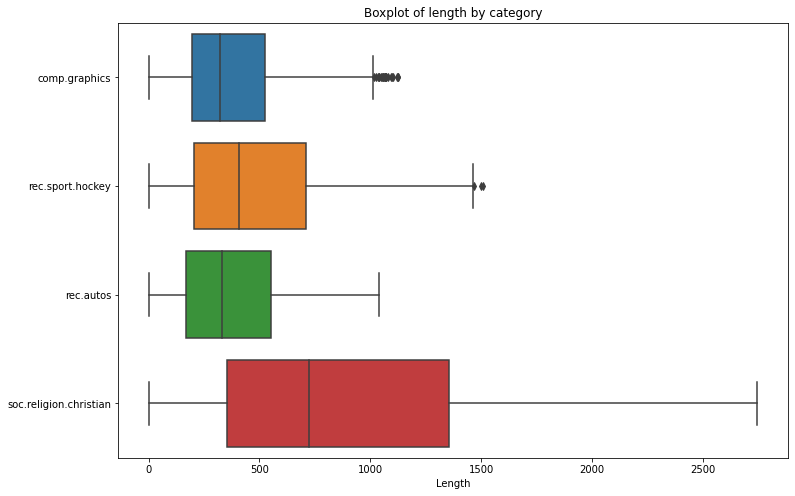

In [ ]:
import seaborn as sns
eightyfive_percent = new_dict_df.quantile(0.85)
new_dict_df_85 = new_dict_df[new_dict_df < eightyfive_percent]

plt.figure(figsize=(12,8))
sns.boxplot(data = new_dict_df_85, orient='h')
plt.xlabel("Length")
plt.title("Boxplot of length by category")
plt.show()

### Linear Regression Class 




In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


### Logistic Regression Class / imdb data 

In [ ]:
from scipy.optimize.nonlin import dot
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e3, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    def ce(self, X,y):

        return -np.sum(y * np.log(self.predict(X)))
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
    
    def check_grad(self,x,y):
        N,D = x.shape
        w = self.w.copy()
        w1 = w + self.epsilon
        w2 = w - self.epsilon
        a1 = np.dot(x, w1)
        a2 = np.dot(x, w2)
        ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
        ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
        dw_num = (ce1 - ce2)/(2*self.epsilon) # approximated gradient
        dw_cal = self.gradient(x,y).sum() * N        

        return (dw_cal - dw_num)**2/(dw_cal + dw_num)**2

#### Implementing the Logistic Regression model.

In [ ]:
logistic_model = LogisticRegression(verbose=True, add_bias=False)
y_test_prob = logistic_model.fit(X_train_vector_array,y_train_imdb).predict(X_test_vector_array)

terminated after 1000 iterations, with norm of the gradient equal to 0.014960414519851811
the weight found: [-5.88053374e-02  1.32367510e-02 -1.30624281e-01 -1.80251141e-01
 -8.45349872e-02 -1.53413100e-01  5.09511545e-04 -6.59970550e-02
 -1.54220028e-01 -1.13392325e-01 -1.09803476e-01 -3.22159495e-02
 -2.87660276e-03 -1.77943560e-01 -1.20375824e-01 -7.05471054e-02
 -1.04426982e-01 -1.00731902e-01 -8.03508824e-02  9.67040654e-02
  2.34005602e-02 -1.30944237e-01  9.99339547e-02  3.79514238e-01
 -1.15851276e-01  4.60325740e-02 -8.83854040e-02 -4.39149416e-02
 -7.15999339e-02 -9.65457940e-02 -5.63452602e-02 -1.35109136e-01
  1.69695418e-01  2.91068168e-01  1.15605167e-01 -7.50119411e-02
  1.54825176e-02  1.31937633e-01 -5.77000685e-02 -9.45414708e-02
 -1.20482794e-01 -7.14054766e-02 -1.00790219e-01  1.57523679e-01
 -3.14238593e-02 -1.22228553e-01 -2.12112238e-04  9.98239593e-04
 -1.29526955e-01 -6.83686425e-02 -1.02081555e-01 -1.73383409e-01
  6.54184324e-03  1.54250649e-01 -4.65814323e-0

#### Verifying gradient calculation


In [ ]:
logistic_model.check_grad(X_test_vector_array, y_test_imdb)

4.021573907666266e-11

#### Binary classification AUROC of logistic regression and KNN on the IMDB data 

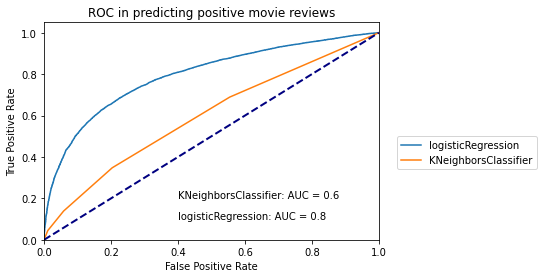

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

fpr_log, tpr_log, _ = roc_curve(y_test_imdb, y_test_prob)
auroc_log = roc_auc_score(y_test_imdb, y_test_prob)


model_K =KNeighborsClassifier()
y_test_prob = model_K.fit(X_train_vector_array, y_train_imdb).predict_proba(X_test_vector_array)[:,1]
fpr_K, tpr_K, _ = roc_curve(y_test_imdb, y_test_prob)
auroc_K = roc_auc_score(y_test_imdb, y_test_prob)


plt.clf()
plt.plot(fpr_log, tpr_log ,label='logisticRegression')
plt.text(0.4, 0.1, 'logisticRegression' + ': AUC = '+ str(round(auroc_log,2)))
plt.plot(fpr_K, tpr_K ,label='KNeighborsClassifier')
plt.text(0.4, 0.2, 'KNeighborsClassifier' + ': AUC = '+ str(round(auroc_K,2)))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting positive movie reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")

i

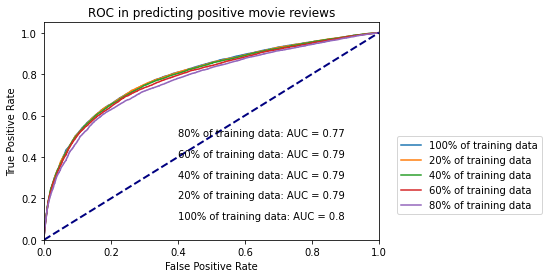

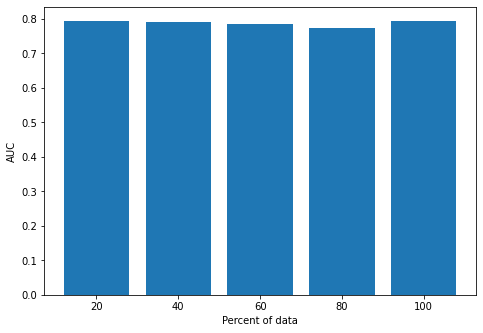

In [ ]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
  X_train_vector_array, y_train_imdb, test_size = 0.20, random_state=1, shuffle=True)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(
  X_train_vector_array, y_train_imdb, test_size = 0.40, random_state=1, shuffle=True)
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(
  X_train_vector_array, y_train_imdb, test_size = 0.60, random_state=1, shuffle=True)
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
  X_train_vector_array, y_train_imdb, test_size = 0.80, random_state=1, shuffle=True)

X_train=[X_train_20,X_train_40,X_train_60,X_train_80]
y_train =[y_train_20,y_train_40,y_train_60,y_train_80]

logistic_model = LogisticRegression(verbose=False, add_bias=False)
perf = {}

perf["100% of training data"] = {'fpr':fpr_log, 'tpr':tpr_log, 'auroc':auroc_log}
name =["20% of training data","40% of training data","60% of training data","80% of training data"]
AUC = []
for i in range(4):
  fit = logistic_model.fit(X_train[i],y_train[i])
  y_test_prob = fit.predict(X_test_vector_array)
  fpr, tpr, _ = roc_curve(y_test_imdb,y_test_prob)
  auroc = roc_auc_score(y_test_imdb, y_test_prob)
  AUC.append(auroc)
  perf[name[i]] = {'fpr': fpr, 'tpr':tpr,'auroc':auroc}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting positive movie reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")


#Plotting bar plot of data percentages and AUC
AUC.append(perf["100% of training data"]['auroc'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['20', '40', '60', '80', '100']
y = AUC
ax.bar(x,y)
ax.set_ylabel('AUC')
ax.set_xlabel('Percent of data')
plt.show()


#### Comparing binary classification AUROC of logistic regression on the IMDB data with the different learning rates





Text(0.5, 1.0, 'ROC in predicting positive movie reviews')

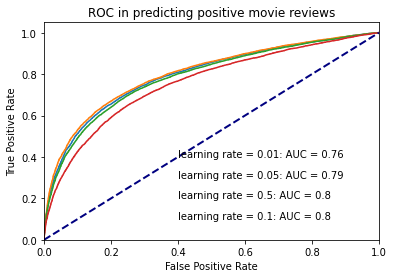

In [ ]:
perf ={}
perf["learning rate = 0.1"] = {'fpr':fpr_log, 'tpr':tpr_log, 'auroc':auroc_log}
learning_rates =[0.5,0.05, 0.01]
for i in range(3):
  logistic_model = LogisticRegression(verbose=False, add_bias=False, learning_rate=learning_rates[i])
  fit = logistic_model.fit(X_train_vector_array,y_train_imdb)
  y_test_prob = fit.predict(X_test_vector_array)
  fpr, tpr, _ = roc_curve(y_test_imdb,y_test_prob)
  auroc = roc_auc_score(y_test_imdb, y_test_prob)
  perf[('learning rate = '+ str(learning_rates[i]))] = {'fpr': fpr, 'tpr':tpr,'auroc':auroc}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting positive movie reviews')



Regularized Ridge regression on IMDB data





Text(0.5, 1.0, 'ROC in predicting positive movie reviews')

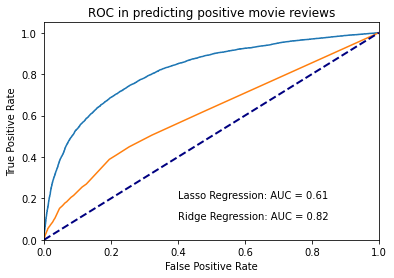

In [ ]:
#Running ridge regression

Ridge_model = Ridge(alpha=1.0)
Ridge_model.fit(X_train_vector_array, y_train_imdb)
y_test_prob_R = Ridge_model.predict(X_test_vector_array)
fpr_R, tpr_R, _ = roc_curve(y_test_imdb,y_test_prob_R)
auroc_R = roc_auc_score(y_test_imdb, y_test_prob_R)

#Running lasso regression

Lasso_model = linear_model.Lasso(alpha=0.05)
Lasso_model.fit(X_train_vector_array, y_train_imdb)
y_test_prob_L = Lasso_model.predict(X_test_vector_array)
fpr_L, tpr_L, _ = roc_curve(y_test_imdb,y_test_prob_L)
auroc_L = roc_auc_score(y_test_imdb, y_test_prob_L)


#Plotting both ROC curves

plt.clf()
plt.plot(fpr_R,tpr_R)
plt.text(0.4, 0.1, 'Ridge Regression: AUC = '+ str(round(auroc_R,2)))
plt.plot(fpr_L,tpr_L)
plt.text(0.4, 0.2, 'Lasso Regression: AUC = '+ str(round(auroc_L,2)))

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting positive movie reviews')


#### Binary classification AUROC of linear regression, logistic regression and KNN on the IMDB data 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


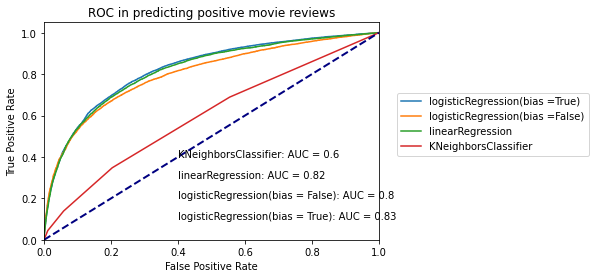

In [ ]:
logistic_model = LogisticRegression(verbose=False, add_bias=False, learning_rate=0.5)
yh = logistic_model.fit(X_train_vector_array,y_train_imdb).predict(X_test_vector_array)
fpr_log_false, tpr_log_false, _ = roc_curve(y_test_imdb, yh)
auroc_log_false = roc_auc_score(y_test_imdb, yh)

logistic_model = LogisticRegression(verbose=False, add_bias=True, learning_rate=0.5)
yh = logistic_model.fit(X_train_vector_array,y_train_imdb).predict(X_test_vector_array)
fpr_log_true, tpr_log_true, _ = roc_curve(y_test_imdb, yh)
auroc_log_true = roc_auc_score(y_test_imdb, yh)

model_Linear =LinearRegression()
y_test_prob = model_Linear.fit(X_train_vector_array, y_train_imdb).predict(X_test_vector_array)
fpr_linear, tpr_linear, _ = roc_curve(y_test_imdb, y_test_prob)
auroc_linear = roc_auc_score(y_test_imdb, y_test_prob)

plt.clf()
plt.plot(fpr_log_true, tpr_log_true ,label='logisticRegression(bias =True)')
plt.text(0.4, 0.1, 'logisticRegression(bias = True)' + ': AUC = '+ str(round(auroc_log_true,2)))

plt.plot(fpr_log_false, tpr_log_false ,label='logisticRegression(bias =False)')
plt.text(0.4, 0.2, 'logisticRegression(bias = False)' + ': AUC = '+ str(round(auroc_log_false,2)))

plt.plot(fpr_linear, tpr_linear ,label='linearRegression')
plt.text(0.4, 0.3, 'linearRegression' + ': AUC = '+ str(round(auroc_linear,2)))

plt.plot(fpr_K, tpr_K ,label='KNeighborsClassifier')
plt.text(0.4, 0.4, 'KNeighborsClassifier' + ': AUC = '+ str(round(auroc_K,2)))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting positive movie reviews')
plt.legend(bbox_to_anchor=(1.04, 0.7), loc="upper left")

In [ ]:
# deleting unnecessary data due to the RAM 

fpr_log_false, tpr_log_false, _ = None, None,None,
auroc_log_false =None

logistic_model = None
yh = None
fpr_log_true, tpr_log_true, _ = None,None,None
auroc_log_true = None
y_test_prob = None
fpr_linear, tpr_linear, _ = None,None,None
auroc_linear = None
X_train_vector_array = None
y_train_imdb = None
X_test_vector_array=None
y_test_imdb =None
X_test_vector = None

train_pos_imdb ,files1 = None, None
train_neg_imdb, files2 = None, None
test_pos_imdb, files3 = None, None
test_neg_imdb, files4 = None, None
vocab = None

X_train,Y_tr = None, None

vectorizer=None

### Multiclass Regression Class / 4-class from the 20 news group data

In [ ]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses,verbose=False):
        self.W = np.random.rand(nFeatures, nClasses)
        self.verbose = verbose

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=1000,epsilon=1e-4):
        self.epsilon = epsilon
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        g = np.inf 
        for i in range(niter):
            g= self.grad(X, y)
            if np.linalg.norm(g) < epsilon:
              print(f'stopped because gradient is less than epsilon ({epsilon})')
              break
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if self.verbose:
                  print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                if self.verbose:
                  print(f"iter {i}: {loss_train:.3f}")
        if self.verbose:
          return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


#### Verifying gradient calculation


In [ ]:
D = X_train_new_cleaned.shape[1]
C = Y_train_new_cleaned.shape[1]
mlr = Multinomial_logistic(D, C)

print(mlr.check_grad(X_train_new_cleaned, Y_train_new_cleaned))

7.074284041188399e-13


#### Implementing the Multiclass Regression model.

In [ ]:
mlr = Multinomial_logistic(D, C,verbose=True)
_, _ = mlr.fit(X_train_new_cleaned, Y_train_new_cleaned, X_test_new_cleaned, Y_test_new_cleaned, niter=10000)

Streaming output truncated to the last 5000 lines.
iter 5000: 1219.341; 850.529
iter 5001: 1219.336; 850.528
iter 5002: 1219.330; 850.526
iter 5003: 1219.324; 850.525
iter 5004: 1219.319; 850.523
iter 5005: 1219.313; 850.522
iter 5006: 1219.307; 850.520
iter 5007: 1219.301; 850.519
iter 5008: 1219.296; 850.517
iter 5009: 1219.290; 850.516
iter 5010: 1219.284; 850.514
iter 5011: 1219.279; 850.512
iter 5012: 1219.273; 850.511
iter 5013: 1219.267; 850.509
iter 5014: 1219.262; 850.508
iter 5015: 1219.256; 850.506
iter 5016: 1219.250; 850.505
iter 5017: 1219.244; 850.503
iter 5018: 1219.239; 850.502
iter 5019: 1219.233; 850.500
iter 5020: 1219.227; 850.499
iter 5021: 1219.222; 850.497
iter 5022: 1219.216; 850.496
iter 5023: 1219.210; 850.494
iter 5024: 1219.205; 850.493
iter 5025: 1219.199; 850.491
iter 5026: 1219.193; 850.490
iter 5027: 1219.188; 850.488
iter 5028: 1219.182; 850.487
iter 5029: 1219.176; 850.485
iter 5030: 1219.171; 850.484
iter 5031: 1219.165; 850.482
iter 5032: 1219.159; 

#### AUROC of multiclass regression and KNN on the 4-class prediction. 

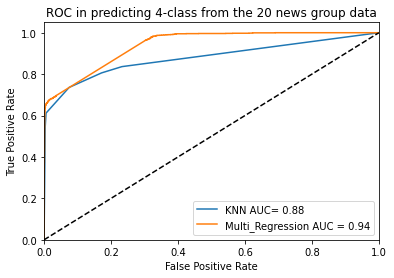

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_K =KNeighborsClassifier()
yh_new_k = model_K.fit(X_train_new_cleaned, Y_train_new_).predict_proba(X_test_new_cleaned)


fpr_k, tpr_k, _ = roc_curve(Y_test_new_cleaned.ravel(), yh_new_k.ravel())
roc_auc_k = auc(fpr_k, tpr_k)

mlr = Multinomial_logistic(D, C,verbose=False)
mlr.fit(X_train_new_cleaned,Y_train_new_cleaned,niter=10000)
yh_new = mlr.predict(X_test_new_cleaned)

fpr_multi, tpr_multi, _ = roc_curve(Y_test_new_cleaned.ravel(), yh_new.ravel())
roc_auc_multi = auc(fpr_multi, tpr_multi)

plt.figure()
plt.plot(fpr_k, tpr_k,
         label='KNN AUC= {0:0.2f}'
               ''.format(roc_auc_k))

plt.plot(fpr_multi, tpr_multi,
         label='Multi_Regression AUC = {0:0.2f}'
               ''.format(roc_auc_multi))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(loc="lower right")
plt.show()

#### AUROC of multi-class regression on the 4-class class from the 20-news-group data with the different size of training datasets

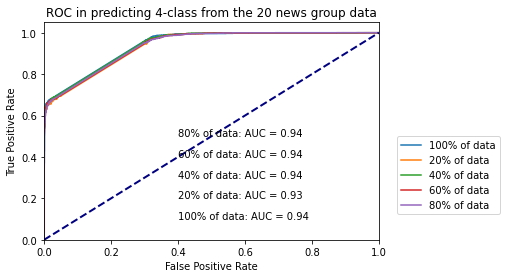

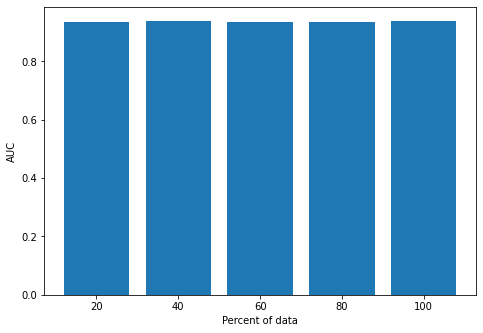

In [ ]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
  X_train_new_cleaned, Y_train_new_cleaned, test_size = 0.20, random_state=1, shuffle=True)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(
  X_train_new_cleaned, Y_train_new_cleaned, test_size = 0.40, random_state=1, shuffle=True)
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(
  X_train_new_cleaned, Y_train_new_cleaned, test_size = 0.60, random_state=1, shuffle=True)
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
  X_train_new_cleaned, Y_train_new_cleaned, test_size = 0.80, random_state=1, shuffle=True)

X_test=[X_test_20,X_test_40,X_test_60,X_test_80]
y_test =[y_test_20,y_test_40,y_test_60,y_test_80]

X_train=[X_train_20,X_train_40,X_train_60,X_train_80]
y_train =[y_train_20,y_train_40,y_train_60,y_train_80]
name =["20% of data","40% of data","60% of data","80% of data"]


perf = {}

perf["100% of data"] = {'fpr':fpr_multi, 'tpr':tpr_multi, 'auroc':roc_auc_multi }


mlr = Multinomial_logistic(D, C,verbose=False)
# mlr.fit(X_train_new,y_train_new,niter=10000)
# yh_new = mlr.predict(X_test_new)
AUC = []
for i in range(4):
  mlr.fit(X_train[i],y_train[i],niter=10000)
  y_test_prob = mlr.predict(X_test[i])
  fpr_, tpr_, _ = roc_curve(y_test[i].ravel(),y_test_prob.ravel())
  auroc_ = auc(fpr_, tpr_)
  AUC.append(auroc_)
  perf[name[i]] = {'fpr': fpr_, 'tpr':tpr_,'auroc':auroc_}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")

#Plotting bar plot of data percentages and AUC
AUC.append(roc_auc_multi)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['20', '40', '60', '80', '100']
y = AUC
ax.bar(x,y)
ax.set_ylabel('AUC')
ax.set_xlabel('Percent of data')
plt.show()


#### AUROC of multi-class regression on the 4-class class from the 20-news-group data with the different learning rates

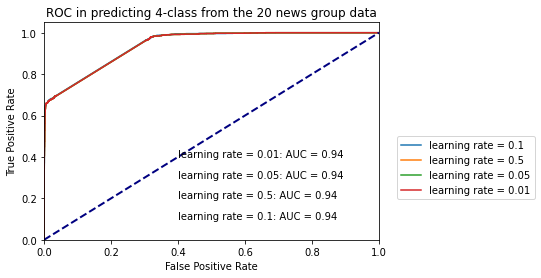

In [ ]:
perf = dict()
learning_rates =[0.5,0.05, 0.01,0.001]

perf["learning rate = 0.1"] = {'fpr':fpr_multi, 'tpr':tpr_multi, 'auroc':roc_auc_multi }

for i in range(3):
  mlr.fit(X_train_new_cleaned,Y_train_new_cleaned, lr= learning_rates[i])
  y_test_prob = mlr.predict(X_test_new_cleaned)
  fpr_, tpr_, _ = roc_curve(Y_test_new_cleaned.ravel(),y_test_prob.ravel())
  auroc_ = auc(fpr_, tpr_)
  perf[('learning rate = '+ str(learning_rates[i]))] = {'fpr': fpr_, 'tpr':tpr_,'auroc':auroc_}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")



#### AUROC of multi-class regression on the 4-class class from the 20-news-group data with the different epsilon values

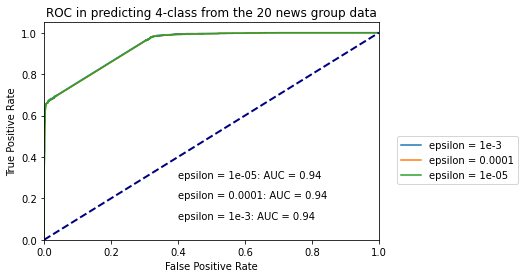

In [ ]:
perf = dict()
epsilons =[1e-4,1e-5]

perf["epsilon = 1e-3"] = {'fpr':fpr_multi, 'tpr':tpr_multi, 'auroc':roc_auc_multi }

for i in range(len(epsilons)):
  mlr.fit(X_train_new_cleaned,Y_train_new_cleaned, epsilon = epsilons[i], niter=int(1e5))
  y_test_prob = mlr.predict(X_test_new_cleaned)
  fpr_, tpr_, _ = roc_curve(Y_test_new_cleaned.ravel(),y_test_prob.ravel())
  auroc_ = auc(fpr_, tpr_)
  perf[('epsilon = '+ str(epsilons[i]))] = {'fpr': fpr_, 'tpr':tpr_,'auroc':auroc_}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")



#### Cross validation

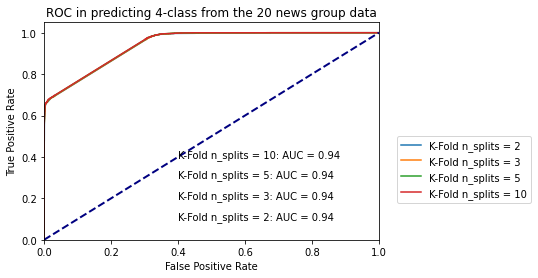

In [ ]:
perf = dict()
nsplits =[2,3,5,10]
y_fold=[]
yh_fold=[]
#X_train_20, X_test_20, y_train_20, y_test_20

for i in range(len(nsplits)):
  kf =KFold(n_splits=nsplits[i], random_state =1, shuffle=True)
  y_= np.zeros_like(Y_all_new_cleaned)
  yh_ = np.zeros_like(Y_all_new_cleaned)
  for train_index, test_index in kf.split(X_new_all_cleaned):
    mlr.fit(X_new_all_cleaned[train_index],Y_all_new_cleaned[train_index])
    y_[test_index] = Y_all_new_cleaned[test_index]
    yh_[test_index] = mlr.predict(X_new_all_cleaned[test_index])
  y_fold.append(y_)
  yh_fold.append(yh_)


for i in range(len(nsplits)):
  fpr_, tpr_, _ = roc_curve(y_fold[i].ravel(),yh_fold[i].ravel())
  auroc_ = auc(fpr_, tpr_)
  perf[('K-Fold n_splits = '+ str(nsplits[i]))] = {'fpr': fpr_, 'tpr':tpr_,'auroc':auroc_}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")

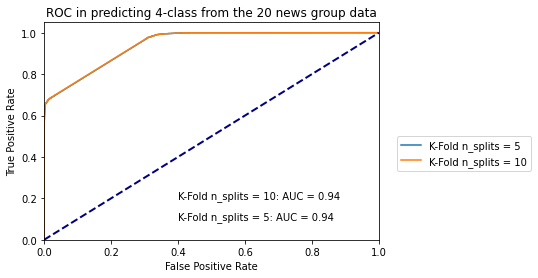

In [ ]:
perf = dict()
nsplits =[5,10]
y_fold=[]
yh_fold=[]
#X_train_20, X_test_20, y_train_20, y_test_20

for i in range(len(nsplits)):
  kf =KFold(n_splits=nsplits[i], random_state =1, shuffle=True)
  y_= np.zeros_like(Y_all_new_cleaned)
  yh_ = np.zeros_like(Y_all_new_cleaned)
  for train_index, test_index in kf.split(X_new_all_cleaned):
    mlr.fit(X_new_all_cleaned[train_index],Y_all_new_cleaned[train_index])
    y_[test_index] = Y_all_new_cleaned[test_index]
    yh_[test_index] = mlr.predict(X_new_all_cleaned[test_index])
  y_fold.append(y_)
  yh_fold.append(yh_)


for i in range(len(nsplits)):
  fpr_, tpr_, _ = roc_curve(y_fold[i].ravel(),yh_fold[i].ravel())
  auroc_ = auc(fpr_, tpr_)
  perf[('K-Fold n_splits = '+ str(nsplits[i]))] = {'fpr': fpr_, 'tpr':tpr_,'auroc':auroc_}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting 4-class from the 20 news group data')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")